# CIS6800: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 18 at 11:59 p.m.
* Part (b) Oct. 23 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train.

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
# try:
#     import dataset
#     import model
#     import train
#     import inference
# except ModuleNotFoundError:
#     pass

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this. You can find the dataset set here: https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install git+https://github.com/PyTorchLightning/pytorch-lightning

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-czwj3sgc
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-czwj3sgc
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 359 kB 67.5 MB/s 
     |████████████████████████████████| 107 kB 86.5 MB/s 
     |████████████████████████████████| 529 kB 72.8 MB/s 
     |████████████████████████████████| 66 kB 5.4 MB/s 
     |████████████████████████████████| 87 kB 8.3 MB/s 
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████

In [ ]:
cd /content/drive/MyDrive/data_rusk/

/content/drive/.shortcut-targets-by-id/1wa7AejJ3yk94qfRHbuZXLOYNlMwm8SPB/data_rusk


In [ ]:
import h5py    
import numpy as np  

def load_data():
  images_file = h5py.File('hw3_mycocodata_img_comp_zlib.h5','r') 
  masks_file = h5py.File('hw3_mycocodata_mask_comp_zlib.h5','r')
  

  images = np.array(images_file['data'])
  masks = np.array(masks_file['data'])
  bboxes = np.load('hw3_mycocodata_bboxes_comp_zlib.npy', allow_pickle=True)
  labels = np.load('hw3_mycocodata_labels_comp_zlib.npy', allow_pickle=True)

  return images, masks, labels, bboxes


In [ ]:
import matplotlib.pyplot as plt
import torch

images, masks, labels, bboxes = load_data()

print('images.shape: ', images.shape)
print('masks.shape: ', masks.shape)
print('labels.shape: ', labels.shape)
print('bboxes.shape: ', bboxes.shape)

label_based_masks = []
cur_pointer = 0
for label in labels:
  cur_mask = np.empty((len(label), 300, 400))

  for i in range(len(label)):
    cur_mask[i] = masks[cur_pointer]
    cur_pointer += 1
  label_based_masks.append(cur_mask)

label_based_masks = np.array(label_based_masks)

images.shape:  (3265, 3, 300, 400)
masks.shape:  (3843, 300, 400)
labels.shape:  (3265,)
bboxes.shape:  (3265,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class SoloDataset(Dataset):

    def __init__(self, images, masks, labels, bboxes, image_transform=None, mask_transform = None):
    
        self.images = images
        self.masks = masks
        self.labels = labels
        self.bboxes = bboxes

        self.image_transform = image_transform
        self.mask_transform = mask_transform


    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):

        image = self.images[idx].astype('uint8').transpose(1,2,0)
        # image = self.images[idx]
        label = self.labels[idx].astype('float32')
        # num_labels = len(label)
        mask = torch.tensor(self.masks[idx].astype('float64'))
        bbox = self.bboxes[idx].astype('float32')

        # print('in get item: ', image.shape)
        

        if self.image_transform:
          image = self.image_transform(image)
          mask = self.mask_transform(mask)
          x_scale = 800.0 / 300.0
          y_scale = 1088.0 / 400.0
          for i, box in enumerate(bbox):
            bbox[i][0] = box[0] * x_scale
            bbox[i][1] = box[1] * y_scale
            bbox[i][2] = box[2] * x_scale
            bbox[i][3] = box[3] * y_scale
 
        return image, label, mask, bbox

In [ ]:
from pytorch_lightning.core.datamodule import LightningDataModule
from torch.utils.data import random_split, DataLoader

class SoloDataModule(LightningDataModule):
    def __init__(self, dataset, batch_size=32):
        super().__init__()

        self.dataset = dataset
        self.batch_size = batch_size

        return

    def setup(self, stage=None):
        val_split = int(0.05 * len(self.dataset))
        test_split = int(0.05 * len(self.dataset))  # 5% of data to be used as validation set
        self.train_data, self.valid_data, self.test_data = random_split(self.dataset, [len(self.dataset)-val_split-test_split, val_split, test_split])

        return
        

    def train_dataloader(self):
        
        # Generating train_dataloader
        return DataLoader(self.train_data, batch_size = self.batch_size)
  
    def val_dataloader(self):
        
        # Generating val_dataloader
        return DataLoader(self.valid_data, batch_size = self.batch_size)
    
    def predict_dataloader(self):
        
        # Generating val_dataloader
        return DataLoader(self.test_data, batch_size = 1)

In [ ]:
image_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                                transforms.Resize((800, 1066)),
                                transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                                transforms.Pad([11,0])
                                ])

mask_transform = transforms.Compose([       
                                transforms.Resize((800, 1066)),
                                transforms.Pad([11,0])
                                ])

SoloData = SoloDataset(images, label_based_masks, labels, bboxes, image_transform, mask_transform)

In [ ]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### RUN THE CELL BELOW FOR INPUT DATA VISUALIZATION

Cats - Blue, Vehicle - Red, Person - Green


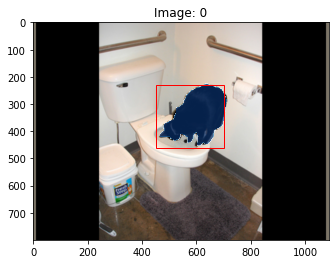

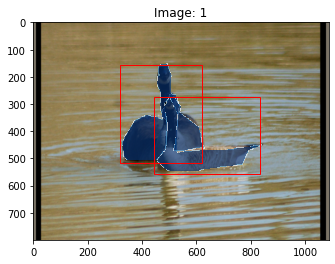

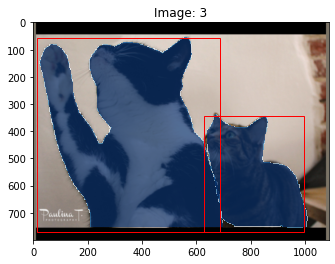

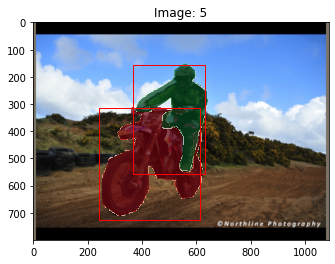

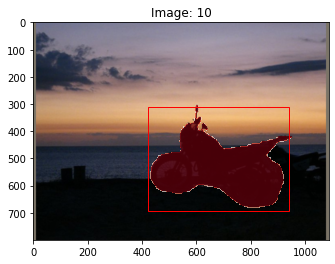

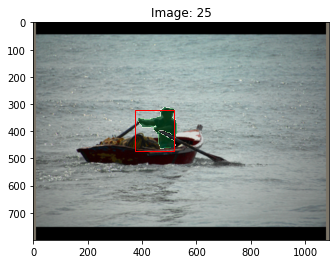

In [ ]:
import random
print('Cats - Blue, Vehicle - Red, Person - Green')
for j, idx in enumerate([0, 1, 3, 5, 10, 25]):
  image, label, mask, bbox = SoloData.__getitem__(idx)

  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle
  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  x = image * STD[:, None, None] + MEAN[:, None, None]

  plt.imshow(x.permute(1, 2, 0))
  label_to_color = {}
  label_to_color[1] = 'Reds'
  label_to_color[2] = 'Greens'
  label_to_color[3] = 'Blues'

  for i in range(mask.shape[0]):
    masked = np.ma.masked_where(mask[i] == 0, mask[i])
    plt.imshow(masked, cmap = label_to_color[int(label[i])], interpolation = 'none', alpha=0.7)
    box = Rectangle((bbox[i][0], bbox[i][1]), bbox[i][2] - bbox[i][0], bbox[i][3] - bbox[i][1],  linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(box)
  plt.title('Image: %d' %idx)
  plt.show()


### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.
 
#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [ ]:
from torch.nn import functional as F 
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def matrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

In [ ]:
import pytorch_lightning as pl
import torchvision
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

class CategoryBranch(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.conv_list = nn.ModuleList()
    self.group_norm_list = nn.ModuleList()
    for i in range(7):
      self.conv_list.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
      self.group_norm_list.append(nn.GroupNorm(num_groups=32, num_channels=256))
    self.relu = nn.ReLU()
    self.out = nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1, bias=True)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    for i in range(7):
      x = self.conv_list[i](x)
      x = self.group_norm_list[i](x)
      x = self.relu(x)
    x = self.out(x)
    x = self.sigmoid(x)
    return x



class MaskBranch(pl.LightningModule):
  def __init__(self, num_grids):
    super().__init__()
    self.conv_list = nn.ModuleList()
    self.group_norm_list = nn.ModuleList()
    self.conv_list.append(nn.Conv2d(258, 256, kernel_size=3, stride=1, padding=1, bias=False))
    self.group_norm_list.append(nn.GroupNorm(num_groups=32, num_channels=256))
    for i in range(1,7):
      self.conv_list.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
      self.group_norm_list.append(nn.GroupNorm(num_groups=32, num_channels=256))
    self.relu = nn.ReLU()
    self.out_list = nn.ModuleList()
    for n in num_grids:
      self.out_list.append(nn.Conv2d(256, n**2, kernel_size=1, stride=1, padding=1, bias=True))
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, fpn_level):
    for i in range(7):
      x = self.conv_list[i](x)
      x = self.group_norm_list[i](x)
      x = self.relu(x)
    x = self.out_list[fpn_level](x)
    x = self.sigmoid(x)

    return x


class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5, matrixNMS_thresh=0.2),
        'input_image_size': (800, 1088)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone

        self.train_losses = []
        self.val_losses = []

        self.category_branch = CategoryBranch()
        self.mask_branch = MaskBranch(self._default_cfg['num_grids'])

        # For generating targets
        self.shapes_transform = []
        self.input_img_size = (800, 1088)
        for i in range(len(self.num_grids)):
          x = int(self.input_img_size[0]/self._default_cfg['strides'][i])
          y = int(self.input_img_size[1] / self._default_cfg['strides'][i])
          transform = transforms.Resize(size=(2*x, 2*y))
          self.shapes_transform.append(transform)
        
    def focal_loss(self, alpha, gamma, p_hat, category_mask):
      object_focal_loss = -1 * alpha * torch.pow(1-p_hat, gamma) * torch.log(p_hat) * category_mask
      background_focal_loss = -1 * (1-alpha) * torch.pow(1-(1-p_hat), gamma) * torch.log(1-p_hat) * torch.logical_not(category_mask)
      return object_focal_loss, background_focal_loss

    def category_loss(self, cat_predictions, cat_targets, active_levels):
      alpha = self._default_cfg['cate_loss_cfg']['alpha']
      gamma = self._default_cfg['cate_loss_cfg']['gamma']
      num_classes = self._default_cfg['num_classes']
      num_grids = self._default_cfg['num_grids']
      loss = []
      for target_num in range(len(cat_targets)):
        cur_loss = []
        for cur_grid in range(len(num_grids)):
          object_loss = 0
          background_loss = 0
          S = num_grids[cur_grid]
          for category in [1, 2, 3]:
            p_hat = cat_predictions[cur_grid][target_num][category - 1, :, :]
            if active_levels[target_num][cur_grid]:
              category_mask = (cat_targets[target_num][cur_grid] == category)
              # object_focal_loss = -1 * alpha * torch.pow(1-p_hat, gamma) * torch.log(p_hat) * category_mask
              object_focal_loss, background_focal_loss = self.focal_loss(alpha, gamma, p_hat, category_mask)
              # background_focal_loss = -1 * (1-alpha) * torch.pow(1-(1-p_hat), gamma) * torch.log(1-p_hat) * torch.logical_not(category_mask)
              object_loss += torch.sum(object_focal_loss)
              background_loss += torch.sum(background_focal_loss)
            else:
              # _, background_focal_loss = self.focal_loss(self, alpha, gamma, p_hat, category_mask)
              background_focal_loss = -1 * (1-alpha) * torch.pow(1-(1-p_hat), gamma) * torch.log(1-p_hat) 
              background_loss += torch.sum(background_focal_loss)
          cur_loss.append(((object_loss + background_loss) / (S*S*num_classes)))
        cur_loss = torch.stack(cur_loss)
        cur_loss = torch.mean(cur_loss)
        loss.append(cur_loss)
      loss = torch.stack(loss)
      loss = torch.mean(loss)
      return loss

    def mask_loss(self, mask_predictions, mask_targets, active_masks, active_levels):
      loss = []
      for target_num in range(len(mask_targets)):
        loss_sample = []
        for cur_grid in range(len(self._default_cfg['num_grids'])):
          s = self._default_cfg['num_grids'][cur_grid]
          if active_levels[target_num][cur_grid]:
            act = active_masks[target_num][cur_grid]
            loss_mask = self.dice_loss(mask_predictions[cur_grid][target_num][act], mask_targets[target_num][cur_grid][act])
            loss_mask = torch.mean(loss_mask)
            loss_sample.append(loss_mask)
        loss_sample = torch.mean(torch.stack(loss_sample))
        loss.append(loss_sample)
      loss = torch.mean(torch.stack(loss))
      return loss
    
      

    def dice_loss(self, pred, target):

      smooth = 1.

      # have to use contiguous since they may from a torch.view op
      iflat = pred.contiguous().view(-1)
      tflat = target.contiguous().view(-1)
      intersection = (iflat * tflat).sum()

      A_sum = torch.sum(iflat * iflat)
      B_sum = torch.sum(tflat * tflat)
      
      return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )


    def loss_fn(self, category_predictions, mask_predictions, category_targets, mask_targets, active_masks, active_levels):
      lambda_category = self._default_cfg['cate_loss_cfg']['weight']
      lambda_mask = self._default_cfg['mask_loss_cfg']['weight']
      
      category_loss = self.category_loss(category_predictions, category_targets, active_levels)
      mask_loss = self.mask_loss(mask_predictions, mask_targets, active_masks, active_levels)
      loss = lambda_category*category_loss + lambda_mask*mask_loss
      return loss, category_loss, mask_loss


    def coordconv(self, input):

      # print('input shape', input.shape)
      batch_size, _, image_height, image_width = input.size()


      y_coords = 2.0 * torch.arange(image_height).unsqueeze(
          1).expand(image_height, image_width) / (image_height - 1.0) - 1.0
      x_coords = 2.0 * torch.arange(image_width).unsqueeze(
          0).expand(image_height, image_width) / (image_width - 1.0) - 1.0

      coords = torch.stack((y_coords, x_coords), dim=0)

      coords = torch.unsqueeze(coords, dim=0).repeat(batch_size, 1, 1, 1)

      image = torch.cat((coords.to(input.device), input), dim=1)
      # print('image.shape', image.shape)

      return image

    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling

    def forward(self, images):
        # you can modify this if you want to train the backbone
      feature_pyramid = [v for v in self.backbone(images.float()).values()] # this has strides [4,8,16,32,64]
      category_predictions = []
      mask_predictions = []
      for i in range(len(feature_pyramid)):
        # print('feature_pyramid[i].shape', feature_pyramid[i].shape)
        input_category_branch = nn.functional.interpolate(feature_pyramid[i], size=(self.num_grids[i], self.num_grids[i]), mode='bilinear')
        # print('category_branch_input.shape', category_branch_input.shape)
        output_category_branch = self.category_branch(input_category_branch)
        if i == 0:
          input_mask_branch = nn.functional.interpolate(feature_pyramid[i], size=(int(800 / self._default_cfg['strides'][0]), int(1088 / self._default_cfg['strides'][0])))
        elif i == len(feature_pyramid)-1:
          input_mask_branch = nn.functional.interpolate(feature_pyramid[i], size=(int(800 / self._default_cfg['strides'][-1]), int(1088 / self._default_cfg['strides'][-1])))
        else:
          input_mask_branch = feature_pyramid[i]
        # print('input_mask_branch.shape', input_mask_branch.shape)
        input_mask_branch = self.coordconv(input_mask_branch)
        # print('input_mask_branch.shape', input_mask_branch.shape)
        output_mask_branch = self.mask_branch(input_mask_branch, i)
        output_mask_branch = nn.functional.interpolate(output_mask_branch, size=(int(2*800 / self._default_cfg['strides'][i]), int(2*1088 / self._default_cfg['strides'][i])), mode='bilinear')
        mask_predictions.append(output_mask_branch)
        category_predictions.append(output_category_branch)
      return category_predictions, mask_predictions
    
    def training_step(self, batch, batch_idx):
      images, labels, masks, bounding_boxes = batch
      # labels = labels.cpu().numpy()
      bounding_boxes = bounding_boxes.detach().cpu().numpy()
      # print('type(bounding_boxes): ', type(bounding_boxes))
      category_predictions, mask_predictions = self.forward(images)
      category_targets, mask_targets, active_masks, active_levels = self.generate_targets(bounding_boxes, labels, masks)

      loss, cat_loss, m_loss = self.loss_fn(category_predictions, mask_predictions, category_targets, mask_targets, active_masks, active_levels)
      self.log("train_loss", loss, prog_bar=True)
      self.log("train_category_loss", cat_loss, prog_bar=True)
      self.log("train_mask_loss", m_loss, prog_bar=True)

      return {"loss": loss, "category_loss": cat_loss, "mask_loss": m_loss}

    def validation_step(self, batch, batch_idx):
      images, labels, masks, bounding_boxes = batch
      bounding_boxes = bounding_boxes.detach().cpu().numpy()
      category_predictions, mask_predictions = self.forward(images)
      category_targets, mask_targets, active_masks, active_levels = self.generate_targets(bounding_boxes, labels, masks)
      loss, cat_loss, m_loss = self.loss_fn(category_predictions, mask_predictions, category_targets, mask_targets, active_masks, active_levels)
      self.log("val_loss", loss, prog_bar=True)
      self.log("val_category_loss", cat_loss, prog_bar=True)
      self.log("val_mask_loss", m_loss, prog_bar=True)

      return {"loss": loss, "category_loss": cat_loss, "mask_loss": m_loss}
    
    def training_epoch_end(self, outputs):
      loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
      cat_loss = torch.tensor([output["category_loss"] for output in outputs]).mean().item()
      m_loss = torch.tensor([output["mask_loss"] for output in outputs]).mean().item()
      self.train_losses.append((loss, cat_loss, m_loss))
    
    def validation_epoch_end(self, outputs):
      loss = torch.tensor([output["loss"] for output in outputs]).mean().item()
      cat_loss = torch.tensor([output["category_loss"] for output in outputs]).mean().item()
      m_loss = torch.tensor([output["mask_loss"] for output in outputs]).mean().item()
      self.val_losses.append((loss, cat_loss, m_loss))
    
    
    #input image size (1, img_dim) -> batchsize=1
    def inference(self, image): 
      image = image.to(self.device)
      category_predictions, mask_predictions = self.forward(image)
      point_nms_cat_preds = []
      for cat_pred in category_predictions:
        point_nms_cat_preds.append(points_nms(cat_pred))
      
      # sorted_scores, sorted_masks, sorted_categories = self.merge_concat(point_nms_cat_preds, mask_predictions)
      num_levels = len(self._default_cfg['num_grids'])
      num_classes = self._default_cfg['num_classes']
      
      scores = []
      gridcell_indices = []
      fpn_levels = []

      for cur_level in range(num_levels):
        cat_score_max, _ = torch.max(category_predictions[cur_level][0].reshape(num_classes-1, -1), dim=0)
        mask_above_thresh = mask_predictions[cur_level][0] > self._default_cfg['postprocess_cfg']["mask_thresh"]

        cur_gridcell_indices = torch.nonzero(cat_score_max > self._default_cfg['postprocess_cfg']['cate_thresh'])
        cur_gridcell_indices = cur_gridcell_indices[:,0]

        filtered_mask_preds = mask_above_thresh * mask_predictions[cur_level][0]
        Nf = torch.sum(mask_above_thresh, dim=(1,2))
        cur_level_score = cat_score_max * torch.sum(filtered_mask_preds, dim=(1,2)) / Nf
        
        # print(cat_score_max.shape)
        # cur_level_score = cat_score_max * torch.sum(mask_predictions[][0] * mask_above_thresh, dim=(1,2)) / torch.sum(mask_above_thresh, dim=(1,2))
        
        cur_level_score[torch.isnan(cur_level_score)] = 0
        cur_level_score = cur_level_score[cur_gridcell_indices]

        gridcell_indices.append(cur_gridcell_indices)
        fpn_levels.append(cur_level * torch.ones(len(cur_gridcell_indices)))
        scores.append(cur_level_score)

      gridcell_indices, scores, fpn_levels = torch.cat(gridcell_indices), torch.cat(scores), torch.cat(fpn_levels) 
      top_scoring_len = max( len(scores), self._default_cfg['postprocess_cfg']['pre_NMS_num'])
      sorted_score_indices = torch.argsort(scores, descending=True)[:top_scoring_len]
      sorted_scores = scores[sorted_score_indices]
      sorted_fpn_levels = fpn_levels[sorted_score_indices]
      sorted_gridcell_indices = gridcell_indices[sorted_score_indices]

      mask_width = int(self._default_cfg['input_image_size'][1] / 4)
      mask_height = int(self._default_cfg['input_image_size'][0] / 4)
      sorted_categories = []
      sorted_masks = torch.zeros((len(sorted_score_indices), mask_height, mask_width), device=device)
      
      for cur_index in range(len(sorted_gridcell_indices)):
          # cur_level = sorted_fpn_levels[cur_index].int()
          cur_level = int(sorted_fpn_levels[cur_index])
          cur_gridcell = sorted_gridcell_indices[cur_index]

          cur_category = category_predictions[cur_level][0].reshape(self.num_classes-1, -1)
          sorted_categories.append((torch.argmax(cur_category[:,cur_gridcell])).item())

          mask = mask_predictions[cur_level][0][cur_gridcell]
          mask = nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(mask_height, mask_width)).squeeze(0).squeeze(0)
          sorted_masks[cur_index,:,:] = (mask > self._default_cfg['postprocess_cfg']['mask_thresh']).int()
          # sorted_masks[cur_index,:,:] = int(mask > self.postprocess_cfg['mask_thresh'])

      sorted_categories = torch.tensor(sorted_categories)

      matrixNMS_scores = matrixNMS(sorted_masks, sorted_scores)
      final_indices = matrixNMS_scores > self._default_cfg['postprocess_cfg']['matrixNMS_thresh']

      return sorted_categories[final_indices], sorted_masks[final_indices]

        
    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions

    def generate_targets(self, bounding_boxes, labels, masks):
      # Classification 
      category_targets = []
      mask_targets = []
      active_masks = []
      active_levels = []

      batch_size = len(labels)
       

      for bounding_box, label, mask in zip(bounding_boxes, labels, masks): # per image in a batch
        # Image targets and masks for all the FPN levels
        num_fpn_levels = len(self._default_cfg['num_grids'])

        image_category_targets = [None] * num_fpn_levels
        image_mask_targets = [None] * num_fpn_levels
        image_active_levels = torch.zeros((num_fpn_levels), dtype=torch.bool)
        image_active_masks = [None] * num_fpn_levels
        
        widths = bounding_box[:,2] - bounding_box[:,0]
        heights = bounding_box[:,3] - bounding_box[:,1]
        
        wh = np.sqrt(widths * heights)
        
        centers_x = (bounding_box[:,1] + bounding_box[:,3]) / 2
        centers_y = (bounding_box[:,0] + bounding_box[:,2]) / 2

        epsilon_widths = self._default_cfg['epsilon'] * widths
        epsilon_heights = self._default_cfg['epsilon'] * heights

        epsilon_x_left = centers_x - (epsilon_widths / 2)
        epsilon_x_right = centers_x + (epsilon_widths / 2)
        epsilon_y_top = centers_y - (epsilon_heights / 2)
        epsilon_y_bottom = centers_y + (epsilon_heights / 2)

        # print('epsilon_x: ', epsilon_x_left, ' ', epsilon_x_right, '; epsilon_y: ', epsilon_y_top, ' ', epsilon_y_bottom)

        for cur_level in range(num_fpn_levels):

          bbox_idx = np.logical_and(wh >= self._default_cfg['scale_ranges'][cur_level][0], wh <= self._default_cfg['scale_ranges'][cur_level][1])
          bbox_idx = np.nonzero(bbox_idx)[0]

          if len(bbox_idx) > 0:
            cur_category_targets = torch.zeros((self._default_cfg['num_grids'][cur_level], self._default_cfg['num_grids'][cur_level]), device=device) # (S, S))
            cur_mask_targets = torch.zeros((self._default_cfg['num_grids'][cur_level]**2, int(2*800/self._default_cfg['strides'][cur_level]), int(2*1088/self._default_cfg['strides'][cur_level])), device=device) # (S^2, 2*feature_h, 2*feature_w)
            cur_active_masks = torch.zeros(self._default_cfg['num_grids'][cur_level]**2, dtype=torch.bool, device=device) # (S^2,)
          
          grid_cell_x_start = np.arange(0, self.input_img_size[0], self.input_img_size[0]/self._default_cfg['num_grids'][cur_level])
          grid_cell_x_end = grid_cell_x_start + self.input_img_size[0]/self._default_cfg['num_grids'][cur_level]
          grid_cell_y_start = np.arange(0, self.input_img_size[1], self.input_img_size[1]/self._default_cfg['num_grids'][cur_level])
          grid_cell_y_end = grid_cell_y_start + self.input_img_size[1]/self._default_cfg['num_grids'][cur_level]

          for i in bbox_idx:
              bbox = bounding_box[i]
              object_cell_x = np.logical_or(np.logical_and(grid_cell_x_start>=epsilon_x_left[i], grid_cell_x_start <= epsilon_x_right[i]), \
                                          np.logical_and(grid_cell_x_end>=epsilon_x_left[i], grid_cell_x_end <= epsilon_x_right[i]))
              object_cell_x = np.nonzero(np.logical_or(object_cell_x, np.logical_and(grid_cell_x_start<=epsilon_x_left[i], grid_cell_x_end >= epsilon_x_right[i])))[0]
              # print('object_cell_x: ', object_cell_x)
              object_cell_y =np.logical_or(np.logical_and(grid_cell_y_start>=epsilon_y_top[i], grid_cell_y_start <= epsilon_y_bottom[i]), np.logical_and(grid_cell_y_end>=epsilon_y_top[i], grid_cell_y_end <= epsilon_y_bottom[i]))
              object_cell_y = np.nonzero(np.logical_or(object_cell_y, np.logical_and(grid_cell_y_start<=epsilon_y_top[i], grid_cell_y_end >= epsilon_y_bottom[i])))[0]
              # print('object_cell_y: ', object_cell_y)
              object_cell_idx_x = np.repeat(object_cell_x, len(object_cell_y))
              object_cell_idx_y = np.tile(object_cell_y, len(object_cell_x))
              # print('self._default_cfg[\'num_grids\'][cur_level]: ', self._default_cfg['num_grids'][cur_level])
              # print('len(object_cell_x): ', len(object_cell_x))
              # print('len(object_cell_y): ', len(object_cell_y))
              # print('object_cell_idx_x: ', object_cell_idx_x)
              # print('object_cell_idx_y: ', object_cell_idx_y)
              flattened_idx = self._default_cfg['num_grids'][cur_level]*object_cell_idx_y + object_cell_idx_x
              # print('label dtype', label[i].dtype)
              # print('cur', cur_category_targets[object_cell_idx_y, object_cell_idx_x].dtype)
              cur_category_targets[object_cell_idx_y, object_cell_idx_x] = label[i]
              downsampled_mask = self.shapes_transform[cur_level](mask[i].unsqueeze(0)).float()
              # print('flattened_idx: ', flattened_idx)
              cur_mask_targets[flattened_idx,:,:] = torch.cat([downsampled_mask.to(device)]*len(flattened_idx))
              cur_active_masks[flattened_idx] = True

          if len(bbox_idx):
              image_category_targets[cur_level] = cur_category_targets
              image_mask_targets[cur_level] = cur_mask_targets
              image_active_masks[cur_level] = cur_active_masks
              image_active_levels[cur_level] = True

        category_targets.append(image_category_targets)
        mask_targets.append(image_mask_targets)
        active_masks.append(image_active_masks)
        active_levels.append(image_active_levels)

      return category_targets, mask_targets, active_masks, active_levels


    def configure_optimizers(self):
      optimizer = torch.optim.SGD(self.parameters(), lr=0.01/4, weight_decay=1e-4, momentum=0.9)
      scheduler = {"scheduler": torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[26, 32], gamma=0.1)}
      return {"optimizer": optimizer, "lr_scheduler": scheduler}



In [ ]:
SoloDataLoader = SoloDataModule(SoloData, batch_size=1)

In [ ]:
def plot_mask(ax, mask, category_map):
  flattened = category_map.reshape(-1)
  if len(np.nonzero(flattened)) != 0:
    idx = np.nonzero(flattened).reshape(-1)
  else:
    return 

  mask_sum_set = set()
  label_to_color = {}
  label_to_color[1] = 'Reds'
  label_to_color[2] = 'Greens'
  label_to_color[3] = 'Blues'
  for itr in range(len(idx)):
    mask_to_display = torch.zeros((800, 1088))
    i = idx[itr]
    clss = int(flattened[i])
    resize_transform = transforms.Resize((800, 1088))
    mask_to_display = resize_transform(mask[i].unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

    mask_sum = torch.sum(mask_to_display).item()

    if mask_sum not in mask_sum_set: 
      mask_sum_set.add(mask_sum)

      mask_to_display = mask_to_display.cpu().numpy()
    
      masked_mask_to_display = np.ma.masked_where(mask_to_display == 0, mask_to_display)
      ax.imshow(masked_mask_to_display, cmap = label_to_color[int(clss)], interpolation = 'none', alpha = 0.7)

### RUN THE CELL BELOW FOR TARGET ASSIGNMENT VISUALIZATION 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

Cats - Blue, Vehicle - Red, Person - Green


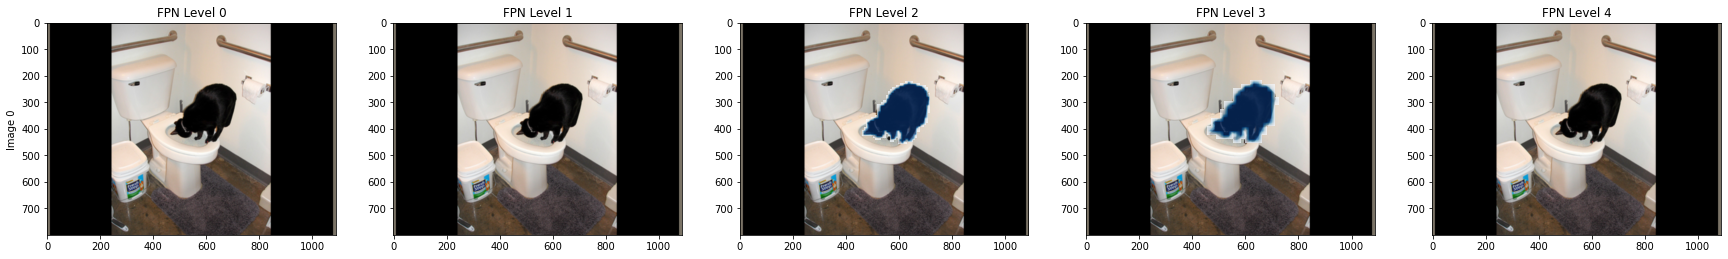

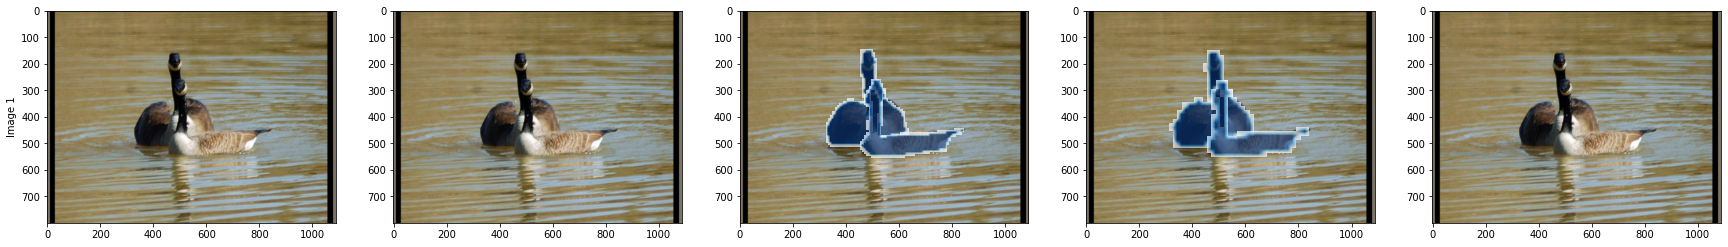

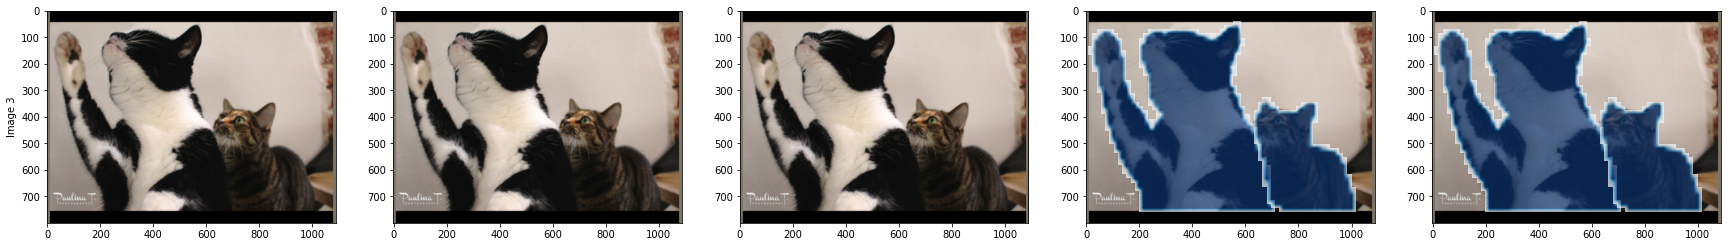

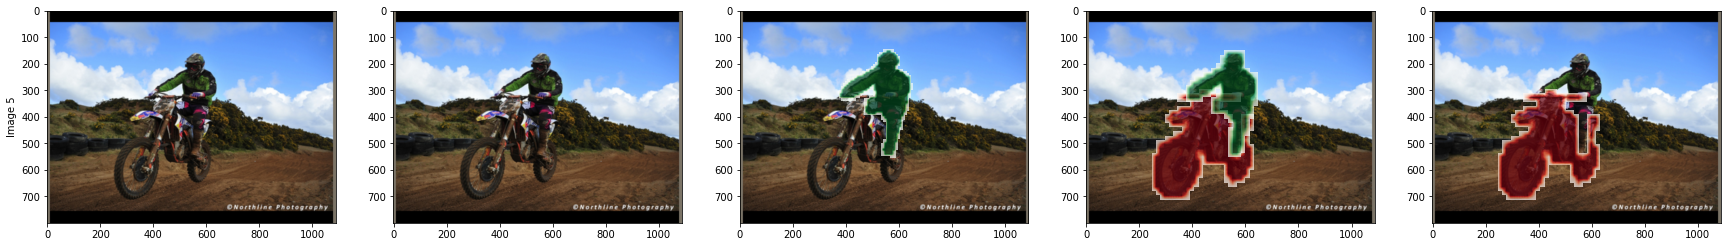

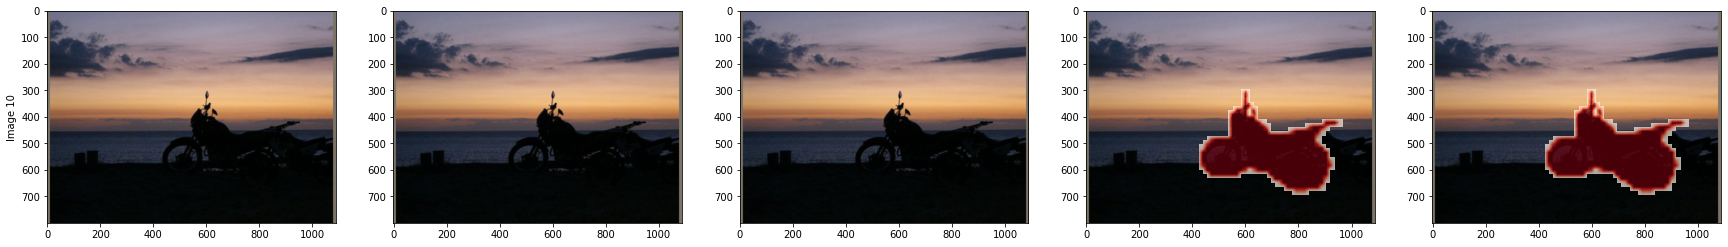

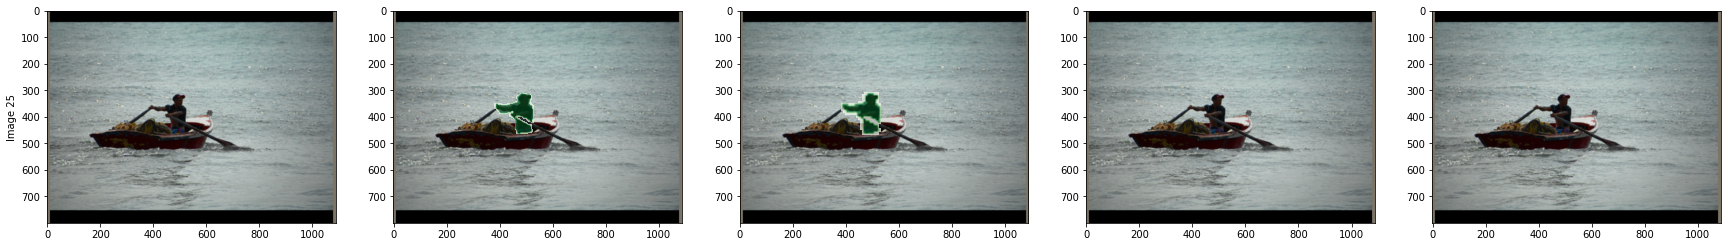

In [ ]:
model = SOLO()

def visualize_targets(model, image_indices):
  sample_images = []
  sample_labels = []
  sample_masks = []
  sample_boxes = []

  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  for image_index in image_indices:
    # print(image_index)
    image, label, mask, box = SoloData.__getitem__(image_index)
    sample_images.append(image)
    label = torch.tensor(label, device = device)
    sample_labels.append(label)
    sample_masks.append(mask)
    # box = box.detach().cpu().numpy()
    sample_boxes.append(box)

  print('Cats - Blue, Vehicle - Red, Person - Green')
  target_categories, target_masks, active_masks, active_levels = model.generate_targets(sample_boxes, sample_labels, sample_masks)
  label_to_color = {}
  label_to_color[1] = 'Reds'
  label_to_color[2] = 'Greens'
  label_to_color[3] = 'Blues'
  for itr, i in enumerate(range(len(target_categories))): # i = image_num
    fig = plt.figure(figsize=(30, 8))
    
    for j in range(len(target_categories[0])): # j = fpn_level
      mask = target_masks[i][j] if active_levels[i][j] else torch.zeros((model.num_grids[j]**2, int(2*800/model.strides[j]), int(2*1088/model.strides[j])))
      category_map = target_categories[i][j] if active_levels[i][j] else torch.zeros((model.num_grids[j], model.num_grids[j]))

      x = sample_images[i] * STD[:, None, None] + MEAN[:, None, None]
      img = np.transpose(x, axes=(1, 2, 0))

      ax = fig.add_subplot(1, 5, j+1)
      ax.imshow(img)
      plot_mask(ax, mask, category_map)
      if j==0:
        ax.set_ylabel('Image %d' %image_indices[itr])
      if i==0:
        ax.set_title('FPN Level %d' %j)
    plt.show()

visualize_targets(model, [0, 1, 3, 5, 10, 25])
    


### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [ ]:
import math
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

num_epochs = 36

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="solo-{epoch:02d}-{val_loss:.2f}",
    save_top_k=num_epochs,
    mode="min",
    every_n_epochs = 10
)

In [ ]:
model = SOLO()
trainer = pl.Trainer(max_epochs=num_epochs, gpus=1, callbacks=[checkpoint_callback], num_sanity_val_steps=0)
trainer.fit(model, SoloDataLoader)
torch.save(model.state_dict(), 'solo.pth')
np.save('train_losses.npy', model.train_losses)
np.save('val_losses.npy', model.val_losses)

Cats - Blue, Vehicle - Red, Person - Green


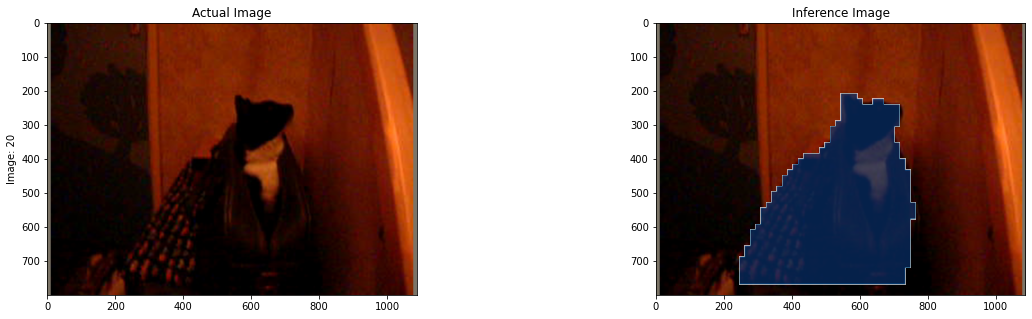

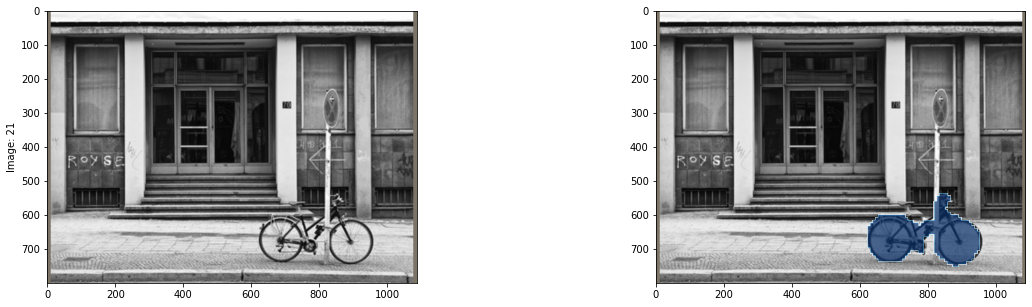

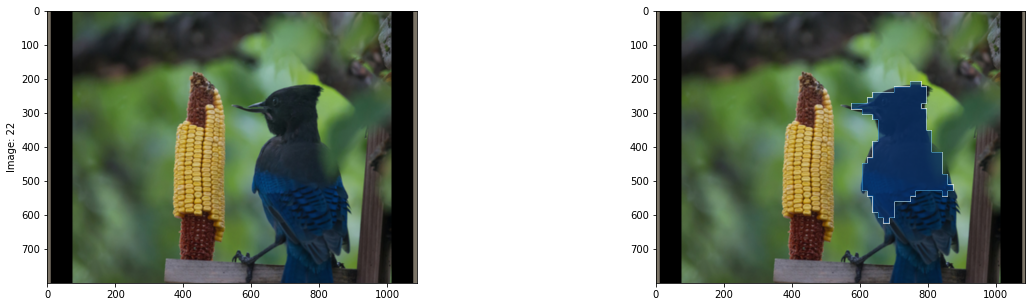

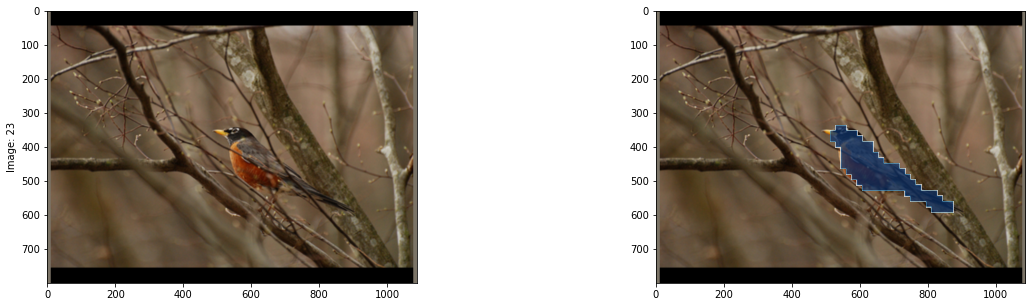

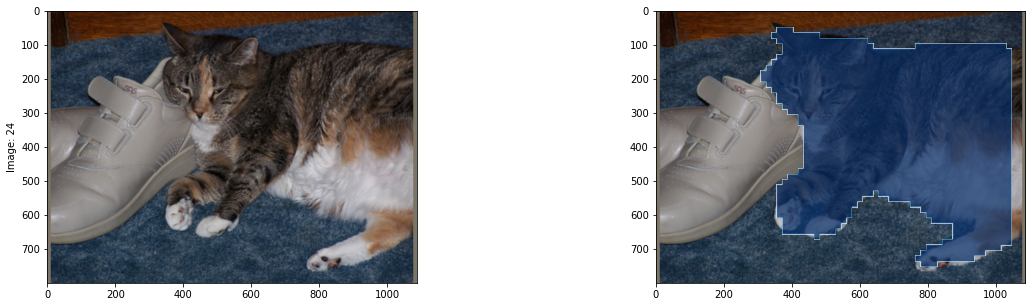

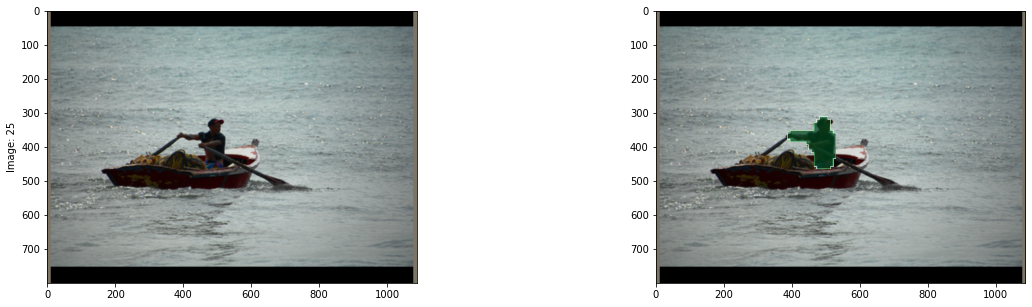

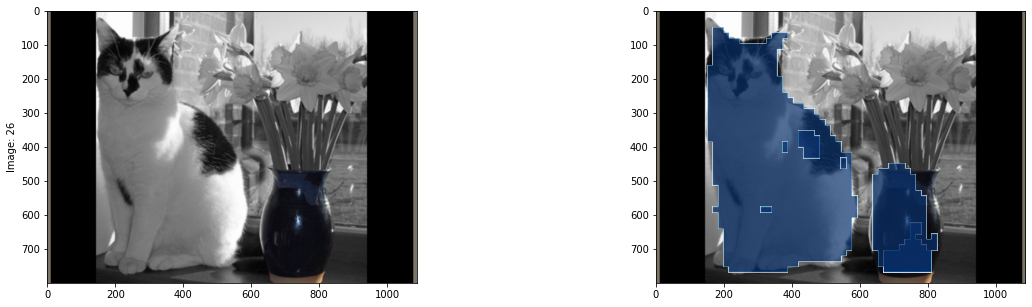

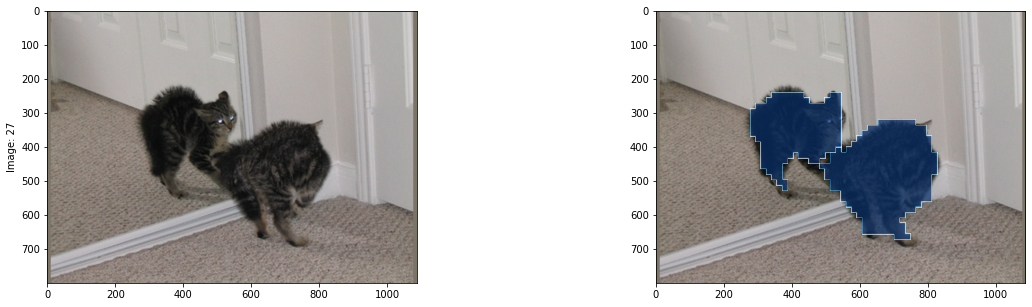

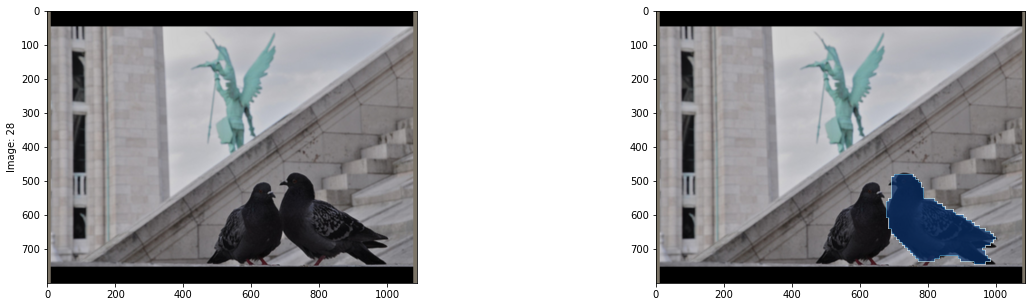

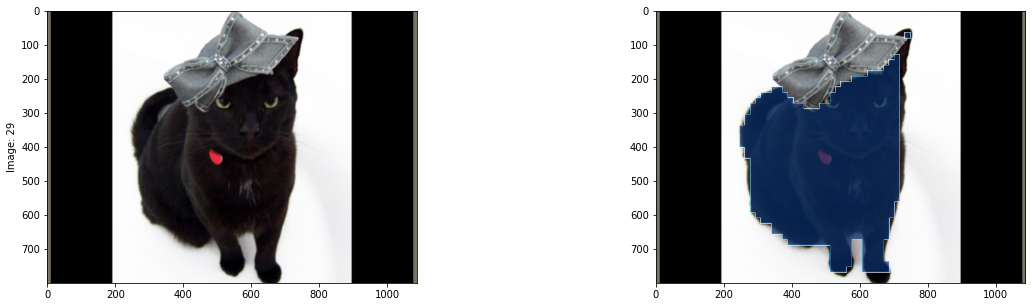

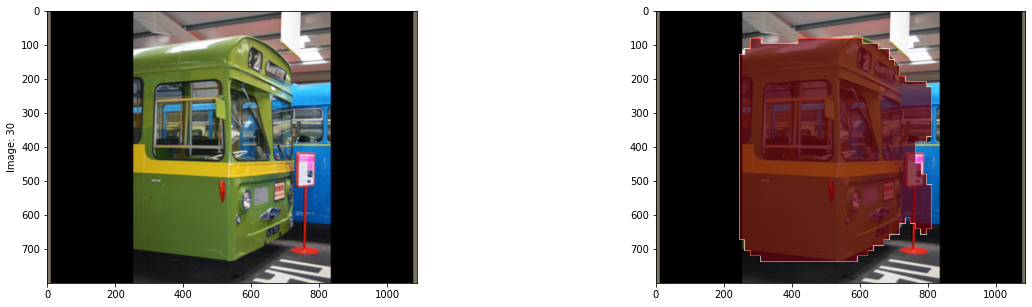

In [31]:
# RUN THIS CELL TO VISUALIZE INFERENCE OUTPUTS
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import logging


logger = logging.getLogger()
old_level = logger.level
model = SOLO().to(device)
model.eval().load_state_dict(torch.load('solo.pth', map_location='cpu'))

print('Cats - Blue, Vehicle - Red, Person - Green')
for j, idx in enumerate([20, 21, 22, 23,24,25,26,27,28,29,30]):
  image, _, m, _ = SoloData.__getitem__(idx)
  fig = plt.figure(figsize=(20, 5))
  ax = fig.add_subplot(1, 2, 1)
  
  # print(image.shape)
  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  x = image * STD[:, None, None] + MEAN[:, None, None]
  ax.set_ylabel('Image: %d' %idx)
  if j==0:

    ax.set_title('Actual Image')

  categories, masks = model.inference(image)
  mask_transform = transforms.Compose([transforms.Resize((800, 1066)), transforms.Pad([11,0])])
  mask = mask_transform(masks).cpu().numpy()
  
  # mask = mask_transform(im.fromarray(mask))
  label = categories.cpu().numpy()
  # print(label)
  ax.imshow(x.permute(1, 2, 0))
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(x.permute(1, 2, 0))
  label_to_color = {}
  label_to_color[0] = 'Reds'
  label_to_color[1] = 'Greens'
  label_to_color[2] = 'Blues'
  if j == 0:
    ax.set_title('Inference Image')

  for i in range(mask.shape[0]):
    masked = np.ma.masked_where(mask[i] == 0, mask[i])
    ax.imshow(masked, cmap = label_to_color[int(label[i])], interpolation = 'none', alpha=0.7)
    # box = Rectangle((bbox[i][0], bbox[i][1]), bbox[i][2] - bbox[i][0], bbox[i][3] - bbox[i][1],  linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(box)
  # plt.title('Image: %d' %idx)
  plt.show()


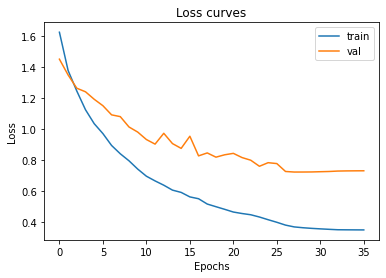

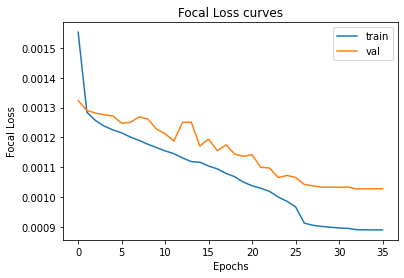

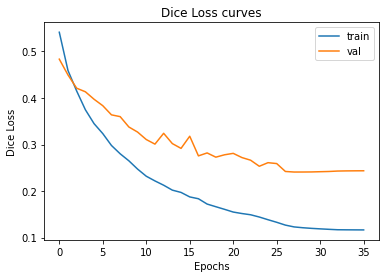

In [ ]:
# RUN THIS CELL TO VISUALIZE DIFFERENT LOSSES 
import matplotlib.pyplot as plt

train_losses = np.load("train_losses.npy")
validation_losses = np.load("val_losses.npy")

plt.figure()
epochs = np.arange(36)
plt.plot(epochs, [loss[0] for loss in train_losses])
plt.plot(epochs, [loss[0] for loss in validation_losses])
plt.title('Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [loss[1] for loss in train_losses])
plt.plot(epochs, [loss[1] for loss in validation_losses])
plt.title('Focal Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Focal Loss')
plt.legend(['train', 'val']) 

plt.figure()
plt.plot(epochs, [loss[2] for loss in train_losses])
plt.plot(epochs, [loss[2] for loss in validation_losses])
plt.title('Dice Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend(['train', 'val']) 

plt.show()


### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

There will likely be a performance benchmark for this project - more details to be announced.

# **Issues encountered and discussion**

- The main issue we encountered for this project was the training duration. It was too long already, so we had to make sure to eliminate any bottlenecks in our code starting with dataloaders, pre-processing, loss function calculation, etc. Also, the RAM kept crashing with normal colab as the dataset was large. Then we had to buy colab pro for better GPU compute power and high RAM. In colab pro, there were again two options for GPU - Standard and premium. Selecting premium GPU made the training 3x-4x faster. But premium GPU access is subject to availability on colab’s backend. So, we went ahead with normal GPU when it’s not available.
- For training, we selected a batch_size of 32. We chose an initial learning rate of 0.025. We did not make any changes to the architecture itself as the loss curves looked fine - no traces of underfitting or overfitting. The final inference visualizations after post-processing also looked reasonable.
- For post processing, we just made one small change during inference. After NMS, instead of selecting the masks with largest scores, we selected the ones with scores above a predefined threshold. This seemed to eliminate most of the false detections. 
- There are a lot of aspects and hyperparameters in this project that could be experimented with. If there was more time, we would’ve spent it on hyperparameter tuning, further looking into loss function and if it can be improved in any way. 
